This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
#%run 0_parameters.ipynb

In [2]:
from where import Where
from what import WhatNet
from retina import Retina
import torch
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Training the Where network

In [4]:
%ls -lh ../data/*pt

-rw-r--r--  1 lolo  staff    12M Mar 13  2019 ../data/2019-03-13_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 14  2019 ../data/2019-03-14_b_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 14  2019 ../data/2019-03-14_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 14  2019 ../data/2019-03-14_train3.pt
-rw-r--r--  1 lolo  staff    12M Mar 14  2019 ../data/2019-03-14_train4.pt
-rw-r--r--  1 lolo  staff    12M Mar 15  2019 ../data/2019-03-15_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 15  2019 ../data/2019-03-15_train_b.pt
-rw-r--r--  1 lolo  staff   8.8M Mar 20  2019 ../data/2019-03-16_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 19  2019 ../data/2019-03-18_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 19  2019 ../data/2019-03-19_bis_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 19  2019 ../data/2019-03-19_train.pt
-rw-r--r--  1 lolo  staff    12M Mar 27  2019 ../data/2019-03-27_train.pt
-rw-r--r--  1 lolo  staff    11M Mar 29  2019 ../data/2019-03-29_train.pt
-rw-r--r--  1 lolo  staff   

In [5]:
from main import init
#args = init(filename='debug')
#args = init(filename='../data/2020-02-02')
args = init(filename='../data/2019-06-13')

args.save_model = True
period = 10
args.sf_0 = 1/period
args.B_sf = 1/period
contrast = 0.7
args.contrast = contrast
args.offset_std = 30

'''args.bn1_bn_momentum = 0
args.bn2_bn_momentum = 0
args.p_dropout = 0.5
args.lr = 1e-4
args.dim1 = 1000
args.dim2 = 1000
args.epochs = 60
args.verbose = True
args.save_model = True'''


'args.bn1_bn_momentum = 0\nargs.bn2_bn_momentum = 0\nargs.p_dropout = 0.5\nargs.lr = 1e-4\nargs.dim1 = 1000\nargs.dim2 = 1000\nargs.epochs = 60\nargs.verbose = True\nargs.save_model = True'

In [6]:
nb_saccades = 1
linear = True
if linear:
    figname = '../paper/fig_result_robust_contrast_linear_{:.1f}_{}'.format(args.contrast, nb_saccades)
else:
    figname = '../paper/fig_result_robust_contrast_{:.1f}_{}'.format(args.contrast, nb_saccades)


In [7]:
figname

'../paper/fig_result_robust_contrast_linear_0.7_1'

In [8]:
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 40,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.5,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.0001,
 'do_adam': True,
 'bn1_bn_momentum': 0.0,
 'bn2_bn_momentum': 0.0,
 'momentum': 0.0,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [9]:
args.epochs = 60

In [10]:
from what import What, WhatTrainer

args.what_offset_max = 25
args.what_offset_std = 15
args.contrast = None
args.noise = 1.


what_suffix = "robust_{}_{}_{}_{}_{}".format(args.sf_0, args.B_sf, args.noise, args.contrast, args.what_offset_std)
what_model_path = "../data/MNIST_cnn_{}.pt".format(what_suffix)
what_model = torch.load(what_model_path)

#what.trainer = WhatTrainer(args,
#                           model=what.model)

#data, target = next(iter(what.trainer.test_loader))



/usr/local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [11]:
%ls ../data/MNIST_cnn_*

../data/MNIST_cnn_0.05_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.06299605249474366_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.07071067811865475_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.07071067811865475_0.1_0.75_0.7_15.pt
../data/MNIST_cnn_0.07937005259840997_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.08908987181403394_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.11224620483093731_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.12599210498948732_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.14142135623730953_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.15874010519681994_0.1_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.05_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.06299605249474366_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.07071067811865475_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.07937005259840997_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.08908987181403394_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.11224620483093731_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.12599210498948732_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.14142135623730953_0.75_0.7.pt
../data/MNIST_cnn_0.1_0.15874010519681994_0.75_0.7.pt
.

In [12]:
what_suffix

'robust_0.1_0.1_1.0_None_15'

In [13]:
args.what_offset_std = 5
what = What(args, model=what_model)
acc = what.trainer.test()


Test set: Average loss: 0.0095, Accuracy: 7028/10000 (70%)



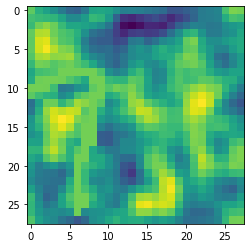

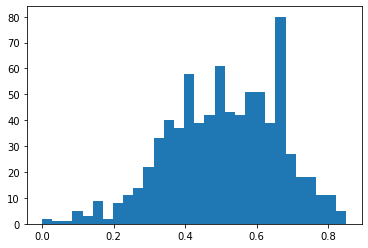

In [14]:
i = 9
data, target = next(iter(what.trainer.test_loader))
plt.imshow(data[i,:,:].reshape((28,28)))
plt.show()
_ = plt.hist(data[i,:,:].detach().numpy().flatten(), 30)

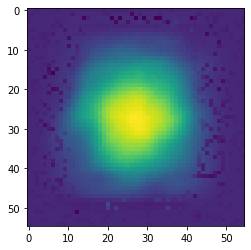

In [15]:
acc_map_path = "../data/MNIST_accuracy_{}.npy".format(what_suffix)
#print(acc_map_path)
acc_map = np.load(acc_map_path)  
plt.imshow(acc_map)

In [16]:
#args.train_batch_size = 20
#args.test_batch_size = 20
#retina = Retina(args)
args.contrast = contrast
args.offset_std =  30
args.offset_max =  40

#plt.show()
#_ = plt.plot(acc_map)
where = Where(args, 
              what_model=what_model, 
              acc_map=acc_map, 
              generate_data=True,
              save_path='tmp/')
              #force_generate=True)
              #) #False, save = False)

#filename_train = args.filename + '_train.pt'
#filename_train = "../data/2019-03-14_train4.pt"
#filename_train = "../data/2019-03-29.pt"
#%ls -lh {filename_train}
#%rm {filename_train}
#%rm  ../data/debug_train.pt

#where.train(filename_train)

tmp/where_model__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128.pt
Dataset : tmp/where_train_dataset__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_100.pt
Generating training dataset
0 100
1 200
2 300
3 400
4 500
5 600
6 700
7 800
8 900
9 1000
10 1100
11 1200
12 1300
13 1400
14 1500
15 1600
16 1700
17 1800
18 1900
19 2000
20 2100
21 2200
22 2300
23 2400
24 2500
25 2600
26 2700
27 2800
28 2900
29 3000
30 3100
31 3200
32 3300
33 3400
34 3500
35 3600
36 3700
37 3800
38 3900
39 4000
40 4100
41 4200
42 4300
43 4400
44 4500
45 4600
46 4700
47 4800
48 4900
49 5000
50 5100
51 5200
52 5300
53 5400
54 5500
55 5600
56 5700
57 5800
58 5900
59 6000
60 6100
61 6200
62 6300
63 6400
64 6500
65 6600
66 6700
67 6800
68 6900
69 7000
70 7100
71 7200
72 7300
73 7400
74 7500
75 7600
76 7700
77 7800
78 7900
79 8000
80 8100
81 8200
82 8300
83 8400
84 8500
85 8600
86 8700
87 8800
88 8900
89 9000
90 9100
91 9200
92 9300
93 9400
94 9500
95 9600
96 9700
97 9800
98 9900
99 10000
100 10100
101 10200
102 10300
103 10400
104 10

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/where_train_dataset__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_100.pt'

In [17]:
plt.imshow(where.trainer.accuracy_map)

NameError: name 'where' is not defined

In [18]:
what_model

WhatNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [19]:
where.model

NameError: name 'where' is not defined

In [20]:
#test_loader = torch.load('/tmp/where_test_dataset__robust_0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_100.pt')

In [21]:
retina_data, accuracy_colliculus = next(iter(where.loader_train))
#retina_data, accuracy_colliculus = next(iter(train_loader))

NameError: name 'where' is not defined

In [22]:
#from where import Normalize
#retina_data = Normalize()(retina_data.float())


In [23]:
i = 3
data_i = retina_data[i,:].float()
plt.plot(data_i.detach().numpy())
x = where.model.bn1(data_i)
plt.plot(x.detach().numpy())
x = F.relu(x)
plt.plot(x.detach().numpy())
plt.show()
x2 = where.model.bn2(x)
plt.plot(data_i.detach().numpy())
plt.plot(x2.detach().numpy())
x2 = F.relu(x2)
plt.plot(x2.detach().numpy())
plt.show()
x3 = where.model.bn3(x2)
plt.plot(data_i.detach().numpy())
plt.plot(x3.detach().numpy())
#plt.plot(where.model.bn1(retina_data.float())[i,:].detach().numpy())

NameError: name 'retina_data' is not defined

In [24]:
import torch

output = torch.sigmoid(where.model(retina_data))
output_test = where.pred_accuracy(retina_data)

NameError: name 'where' is not defined

In [25]:
plt.plot(retina_data[i,:].detach().numpy())

NameError: name 'retina_data' is not defined

In [26]:
plt.plot(output[i, :].detach().numpy())
plt.plot(output_test[i, :])
plt.plot(accuracy_colliculus[i, :].detach().numpy())

NameError: name 'output' is not defined

In [27]:
#retina_data_test, retina_fullfield_test, accuracy_colliculus_test, accuracy_colliculus_fullfield_test, labels_test, i_shift, j_shift = next(iter(test_loader))
retina_data_test, retina_fullfield_test, accuracy_colliculus_test, accuracy_colliculus_fullfield_test, labels_test, i_shift, j_shift = next(iter(where.loader_test))
#(retina_data_test, retina_fullfield_test), (accuracy_colliculus_test, accuracy_colliculus_fullfield_test, labels_test, i_shift, j_shift) = next(iter(where.loader_test))

NameError: name 'where' is not defined

In [28]:
i = 0
_ = plt.plot(retina_fullfield_test[i,:].detach().numpy())

NameError: name 'retina_fullfield_test' is not defined

In [29]:
#plt.plot(data[i,:].detach().numpy())

In [30]:
plt.imshow(retina_fullfield_test[i,:])
plt.show()
plt.imshow(accuracy_colliculus_fullfield_test[i,:])
plt.show()
h = plt.hist(retina_fullfield_test[i,:,:].detach().numpy().flatten(), 30)

NameError: name 'retina_fullfield_test' is not defined

In [31]:
output = torch.sigmoid(where.model(retina_data_test.float()))

NameError: name 'where' is not defined

NameError: name 'where' is not defined

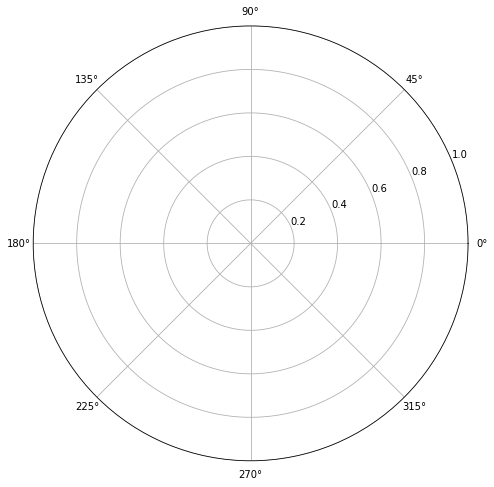

In [32]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus_test[i, :].detach().numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("True")

NameError: name 'where' is not defined

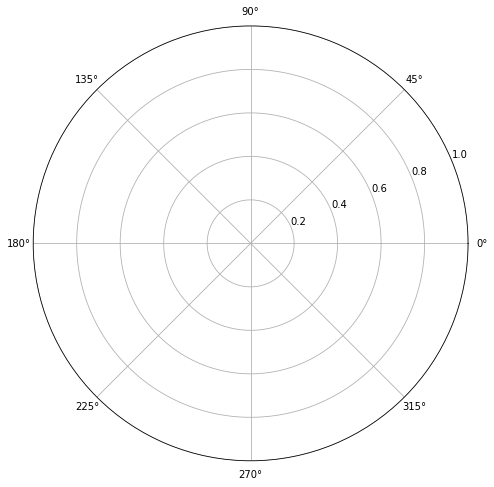

In [33]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, output[i, :].detach().numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("predicted")

# Visualisation of some examples

In [34]:
i = 3
plt.plot(retina_data[i,:].detach().numpy())

NameError: name 'retina_data' is not defined

NameError: name 'where' is not defined

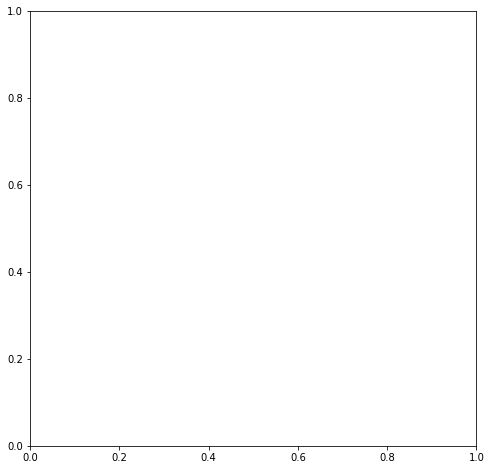

In [35]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax = where.retina.show(ax, where.retina.retina_invert(retina_data[i,:].detach().numpy()))


NameError: name 'where' is not defined

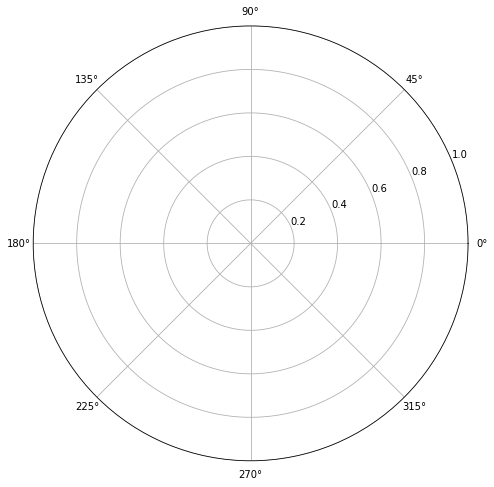

In [36]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[i, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("True")

In [37]:
retina_data

NameError: name 'retina_data' is not defined

In [38]:
min(accuracy_colliculus[3,:])

NameError: name 'accuracy_colliculus' is not defined

In [39]:
print(accuracy_colliculus.shape)
print(args.N_azimuth)
print(args.N_eccentricity) 

print(where.args.N_azimuth)
print(where.args.N_eccentricity) 

NameError: name 'accuracy_colliculus' is not defined

## knowing the target position

In [40]:
idx_start, idx_stop = 0, 20


In [41]:
#positions, data_fullfield, retina_data, accuracy_colliculus = where.minibatch(data[idx_start:idx_stop])
#positions, data_fullfield, retina_data, accuracy_colliculus = where.minibatch(None) #data[idx_start:idx_stop])

In [42]:
retina_data, data_fullfield, accuracy_colliculus, _, label, i_offset, j_offset = next(iter(where.loader_test))

NameError: name 'where' is not defined

In [43]:
plt.plot(retina_data[i,:].detach().numpy())
np.std(retina_data[i,:].detach().numpy())

NameError: name 'retina_data' is not defined

In [44]:
_

(array([ 2.,  1.,  1.,  5.,  3.,  9.,  2.,  8., 11., 14., 22., 33., 40.,
        37., 58., 39., 42., 61., 43., 42., 51., 51., 39., 80., 27., 18.,
        18., 11., 11.,  5.]),
 array([0.        , 0.02836601, 0.05673202, 0.08509804, 0.11346405,
        0.14183007, 0.17019609, 0.1985621 , 0.2269281 , 0.2552941 ,
        0.28366014, 0.31202614, 0.34039217, 0.36875817, 0.3971242 ,
        0.4254902 , 0.4538562 , 0.48222223, 0.5105882 , 0.53895426,
        0.5673203 , 0.59568626, 0.6240523 , 0.6524183 , 0.68078434,
        0.7091503 , 0.73751634, 0.7658824 , 0.7942484 , 0.8226144 ,
        0.8509804 ], dtype=float32),
 <a list of 30 Patch objects>)

In [45]:
plt.plot(accuracy_colliculus[i,:].detach().numpy())

NameError: name 'accuracy_colliculus' is not defined

In [46]:
plt.imshow(data_fullfield[2,:])

NameError: name 'data_fullfield' is not defined

In [47]:
_ = plt.plot(data_fullfield[2,:].detach().numpy())
#data_fullfield *= 255

NameError: name 'data_fullfield' is not defined

In [48]:
import numpy as np
Delta=0

#im = np.zeros((args.test_batch_size, args.w, args.w))
im = np.zeros((idx_stop, where.args.w, where.args.w))
for idx in range(idx_stop): #args.test_batch_size):
    #im[idx, :, :] = where.extract(data_fullfield[idx, :, :], positions[idx]['i_offset'], positions[idx]['j_offset'])
    im[idx, :, :] = where.extract(data_fullfield[idx+Delta, :, :], i_offset[idx+Delta], j_offset[idx+Delta])
proba = where.classify_what(im).detach().numpy()
pred = proba.argmax(axis=1)# get the index of the max log-probability
#acc = proba[:, pred]

print(pred)
label_n = label[idx_start+Delta:idx_stop+Delta].detach().numpy()
print(label_n)
print(np.mean(np.equal(pred, label_n)))

#.detach().numpy().mean() #(pred==label.numpy()).mean()
#print('Accuracy max (knowing the position)=', acc_max)

NameError: name 'where' is not defined

In [49]:
i = 2
plt.imshow(im[i,:,:])
plt.show()
_ = plt.hist(im[i,:,:].flatten(), 30)

NameError: name 'im' is not defined

## Generate a noisy MNIST database

In [50]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import os

#im = np.zeros((args.test_batch_size, args.w, args.w))

from display import get_data_loader
filename_dataset = '../data/noisy-MNIST.pt'

if not os.path.isfile(filename_dataset):
    batch_size = 100
    loader_full = get_data_loader(batch_size=batch_size, train=True, mean=where.args.mean, std=where.args.std, seed=where.args.seed+1)
    im = np.zeros((where.args.train_batch_size, 1, where.args.w, where.args.w))
    im_label = np.zeros(where.args.train_batch_size, dtype = 'int')
    for idx, (data, label) in enumerate (loader_full):
        if idx % 10 == 0:
            print(idx * 100)
        if idx == 500:
            break
        for j in range(batch_size):
            data_fullfield_, i_offset, j_offset = where.display.draw(data[j, 0, :, :].numpy())
            extracted = where.extract(data_fullfield_, i_offset, j_offset)
            im[idx * batch_size + j, 0, :, :] = extracted.reshape(1, 28, 28)
            im_label[idx * batch_size + j] = label[j]
    im = Variable(torch.FloatTensor(im)).to(where.device)
    im_label = Variable(torch.LongTensor(im_label)).to(where.device)
    loader_train = DataLoader(TensorDataset(im, im_label), batch_size=100)
    torch.save(loader_train, filename_dataset)
#.detach().numpy().mean() #(pred==label.numpy()).mean()
#print('Accuracy max (knowing the position)=', acc_max)

In [51]:
if False:
    check_loader = torch.load(filename_dataset)
    im, label = next(iter(check_loader))
    im.shape
    i = 4
    plt.imshow(im[i,0,:,:])
    plt.title(label[i].detach().numpy())

In [52]:
idx = 1
plt.imshow(data_fullfield[idx,:,:])
print(i_offset[idx], j_offset[idx], label[idx])
plt.show()
#f = plt.plot(Normalize()(data_fullfield[idx,:,:]).detach().numpy())
f = plt.plot(data_fullfield[idx,:,:].detach().numpy())

NameError: name 'data_fullfield' is not defined

In [53]:
idx_start, idx_stop = 0, 20

#from main_orig import init
#args = init()
#args.N_azimuth * args.N_eccentricity

NameError: name 'where' is not defined

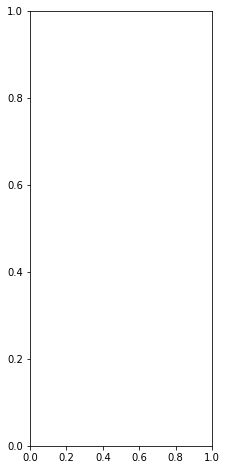

In [54]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(141)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    #ax.set_title(f"i={positions[idx]['i_offset']}, j={positions[idx]['j_offset']}")
    ax.set_title(f"i={i_offset[idx]}, j={j_offset[idx]}")
    
    ax = fig.add_subplot(142)
    data_retina = where.retina.retina(data_fullfield[idx, :, :])
    ax = where.retina.show(ax, where.retina.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(143, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(144)
    ax = where.display.show(ax, im[idx, :, :], do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

## predicting the position of the target

In [55]:
pred_accuracy_colliculus = where.pred_accuracy(retina_data)
print('pred_accuracy_colliculus.shape=', pred_accuracy_colliculus.shape)

NameError: name 'where' is not defined

In [56]:
plt.plot(pred_accuracy_colliculus[2,:])

NameError: name 'pred_accuracy_colliculus' is not defined

In [57]:
im_colliculus = where.retina.accuracy_invert(pred_accuracy_colliculus[0,:])
im_colliculus.shape

NameError: name 'where' is not defined

In [58]:
data_retina

NameError: name 'data_retina' is not defined

NameError: name 'where' is not defined

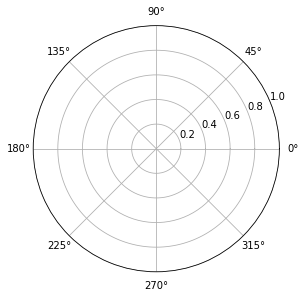

In [59]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))

    ax = fig.add_subplot(131, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_title("Predicted")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
              
    x = where.retina.accuracy_invert(pred_accuracy_colliculus[idx, :])
    ax = fig.add_subplot(132)
    ax.imshow(x, vmin=0, cmap=plt.plasma())
    ax.set_title("Pred visual space")
    
    i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :], do_shortcut=True)
    
    ax = fig.add_subplot(133)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    #ax.set_title(f"i={positions[idx]['i_offset']}/{i_pred}, j={positions[idx]['j_offset']}/{j_pred}")
    ax.set_title(f"i={i_offset[idx]}/{i_pred}, j={j_offset[idx]}/{j_pred}")
    #ax.plot([positions[idx]['j_offset']+args.N_pic//2], [positions[idx]['i_offset']+args.N_pic//2], '+', c='r', ms=26, markeredgewidth=2, alpha=.5)
    ax.plot([j_offset[idx]+args.N_pic//2], [i_offset[idx]+args.N_pic//2], '+', c='r', ms=26, markeredgewidth=2, alpha=.5)
    ax.plot([j_pred+args.N_pic//2], [i_pred+args.N_pic//2], '+', c='b', ms=26, markeredgewidth=2, alpha=.5)
    
    

## doing a saccade at the predicted the position of the target

In [60]:
print(data_fullfield.shape, retina_data.shape, label.shape)

NameError: name 'data_fullfield' is not defined

In [61]:
accuracy = where.test_what(data_fullfield, pred_accuracy_colliculus, label)
#print('mean accuracy =', accuracy.mean())
accuracy

NameError: name 'where' is not defined

In [62]:
where.what_class(data_fullfield, pred_accuracy_colliculus)

NameError: name 'where' is not defined

In [63]:
from display import minmax
pred_accuracy_colliculus = where.pred_accuracy(retina_data)
pred = where.what_class(data_fullfield, pred_accuracy_colliculus)
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    #ax.set_title(f"i={positions[idx]['i_offset']}, j={positions[idx]['j_offset']}")
    ax.set_title(f"i={i_offset[idx]}, j={j_offset[idx]}")
    
    ax = fig.add_subplot(152)
    data_retina = where.retina.retina(data_fullfield[idx, :, :])
    ax = where.retina.show(ax, where.retina.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("Predicted")

    #i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
    i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :], do_shortcut=True)
    ax = fig.add_subplot(155)                 
    ax = where.display.show(ax, where.extract(data_fullfield[idx, :, :], i_pred, j_pred), do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

NameError: name 'where' is not defined

testing on the test set:

# accuracy as a function of eccentricity


In [64]:
ecc_max=.8
N_eccentricities = args.N_eccentricity - 1
#eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))
eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)

NameError: name 'where' is not defined

In [65]:
eccentricities

NameError: name 'eccentricities' is not defined

In [66]:
def test_eccentricities(N_eccentricities=9, ecc_max=.8, do_control=False, linear=False):
    import torch
    from torchvision import datasets, transforms
    from torch.utils.data import TensorDataset, DataLoader
    from where import RetinaFill, CollFill, WhereShift, RetinaBackground, RetinaMask, FullfieldRetinaWhiten 
    from where import FullfieldRetinaTransform, FullfieldToFloatTensor, Normalize, MNIST
    from where import FullfieldCollTransform
    if linear:
        eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)
    else:
        eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))
    #eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)
    batch_size = 1000 #where.args.test_batch_size # data.shape[0]
    #from retina import get_data_loader
    #loader_test = get_data_loader(batch_size=1, train=False, 
    #                              mean=where.args.mean, std=where.args.std, seed=where.args.seed+10)
        
    accuracy_mean, accuracy_std = [], []
    for eccentricity in eccentricities:
        print(eccentricity)
        fullfield_transform = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, radius = eccentricity),
            RetinaBackground(contrast=args.contrast,
                             noise=args.noise,
                             sf_0=args.sf_0,
                             B_sf=args.B_sf),
            RetinaMask(N_pic=args.N_pic),
            FullfieldRetinaWhiten(N_pic=args.N_pic),
            FullfieldRetinaTransform(where.retina.retina_transform_vector),
            FullfieldToFloatTensor(),
            #Normalize(fullfield=True)
            # transforms.Normalize((args.mean,), (args.std,))
        ])
        fullfield_target_transform=transforms.Compose([
                               CollFill(where.accuracy_map, keep_label = True, N_pic=args.N_pic, baseline=0.1),
                               WhereShift(args, baseline = 0.1, keep_label = True),
                               FullfieldCollTransform(where.retina.colliculus_transform_vector, keep_label = True),
                               FullfieldToFloatTensor(keep_label = True)
                           ])
        dataset = MNIST('../data',
                        train=False,
                        download=True,
                        transform=fullfield_transform,
                        target_transform=fullfield_target_transform,
                        )
        data_loader = DataLoader(dataset,
                                 batch_size=batch_size,
                                 shuffle=True)

        '''retina_data = np.zeros((batch_size, where.retina.vsize))
        labels = np.zeros((batch_size))
        data_fullfield = np.zeros((batch_size, where.args.N_pic, where.args.N_pic))        
        accuracy_colliculus = np.zeros((batch_size, where.args.N_azimuth * where.args.N_eccentricity))

        for i in range(batch_size):
            data, label = next(iter(loader_test))
            data_fullfield[i, :, :], i_offset, j_offset = where.display.draw(data[0, 0, :, :].numpy(), 
                                                                   radius=eccentricity)
            positions.append(dict(i_offset=i_offset, j_offset=j_offset))
            retina_data[i, :]  =  where.retina.retina(data_fullfield[i, :, :])
            labels[i] = label
        labels =  Variable(torch.FloatTensor(labels))
        retina_data =  Variable(torch.FloatTensor(retina_data))
        pred_accuracy_colliculus = where.pred_accuracy(retina_data)'''
        
        if nb_saccades >1 and not do_control:
            print('ok')
            accuracy = where.multi_test(nb_saccades, dataloader=data_loader, batch_size=batch_size)
            accuracy_mean.append(accuracy)
        else:
            data, acc = next(iter(data_loader))
            retina_data = data[0]
            data_fullfield = data[1]
            labels = acc[2]
            pred_accuracy_colliculus = where.pred_accuracy(retina_data)
            accuracy_ = where.test_what(data_fullfield, pred_accuracy_colliculus, labels.squeeze(), do_control=do_control)
            accuracy_mean.append(accuracy_.mean())
            accuracy_std.append(accuracy_.std()) # TODO fit with beta distribution'''
        
        
    return eccentricities, np.array(accuracy_mean), np.array(accuracy_std)

In [67]:
from where import where_suffix
import os
suffix = where_suffix(args)
if linear:
    file_path = '../data/eccentricity_accuracy_linear_{}_{}.npy'.format(suffix, nb_saccades)
else:
    file_path = '../data/eccentricity_accuracy_{}_{}.npy'.format(suffix, nb_saccades)
if True : #os.path.isfile(file_path):
    accuracy_mean = {}
    accuracy_std = {}
    eccentricities, ctl_accuracy_mean, ctl_accuracy_std = test_eccentricities(N_eccentricities, linear=linear, do_control=True)
    print(0, 'eccentricities=', eccentricities, ', ctl_accuracy_data=', ctl_accuracy_mean, ' +/- ', ctl_accuracy_std)
    accuracy_mean[0] = ctl_accuracy_mean
    accuracy_std[0] = ctl_accuracy_std
    for nb_saccades in range(1,6):
        eccentricities, sac_accuracy_mean, sac_accuracy_std = test_eccentricities(N_eccentricities, linear=linear)
        print(nb_saccades, 'eccentricities=', eccentricities, ', accuracy_data=', sac_accuracy_mean, ' +/- ', sac_accuracy_std)
        accuracy_mean[nb_saccades] = sac_accuracy_mean
        accuracy_std[nb_saccades] = sac_accuracy_std
        np.save(file_path,[eccentricities, accuracy_mean, accuracy_std])
else:
    data = np.load(file_path)
    eccentricities = data[0]
    accuracy_mean = data[1]
    ctl_accuracy_mean = data[2]

NameError: name 'where' is not defined

In [68]:
from where import where_suffix
suffix = where_suffix(args)
if linear:
    file_path = '../data/eccentricity_accuracy_linear_{}_{}.npy'.format(suffix, nb_saccades)
else:
    file_path = '../data/eccentricity_accuracy_{}_{}.npy'.format(suffix, nb_saccades)
data = np.load(file_path)
#eccentricities = data[0]
#accuracy_mean = data[1]
#ctl_accuracy_mean = data[2]

FileNotFoundError: [Errno 2] No such file or directory: '../data/eccentricity_accuracy_linear__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_1.npy'

In [69]:
file_path

'../data/eccentricity_accuracy_linear__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_1.npy'

In [70]:
#np.save(file_path,[eccentricities, accuracy_mean, accuracy_std])

In [71]:
accuracy_mean

{}

NameError: name 'eccentricities' is not defined

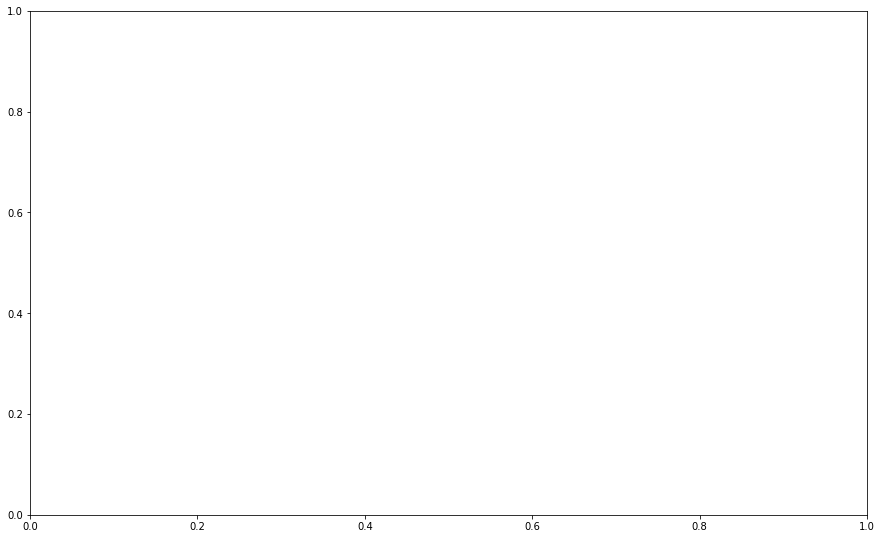

In [72]:
figwidth = 15
fig = plt.figure(figsize = (figwidth, figwidth/1.618))
ax_D = fig.add_subplot(1, 1, 1)
width = .8*np.abs(np.gradient(eccentricities)[0])
colors = ('orange','blue','red','yellow','cyan','purple')
for num_saccade in [1, 0]:
    if num_saccade <2:
        label = str(num_saccade)+' saccade'
    else:
        label = str(num_saccade)+' saccades'
    ax_D.bar(eccentricities, accuracy_mean[num_saccade], width=width, alpha = .5, label = label, color=colors[num_saccade])#yerr=accuracy_std, 
# TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
#ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
#ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1]);

NameError: name 'eccentricities' is not defined

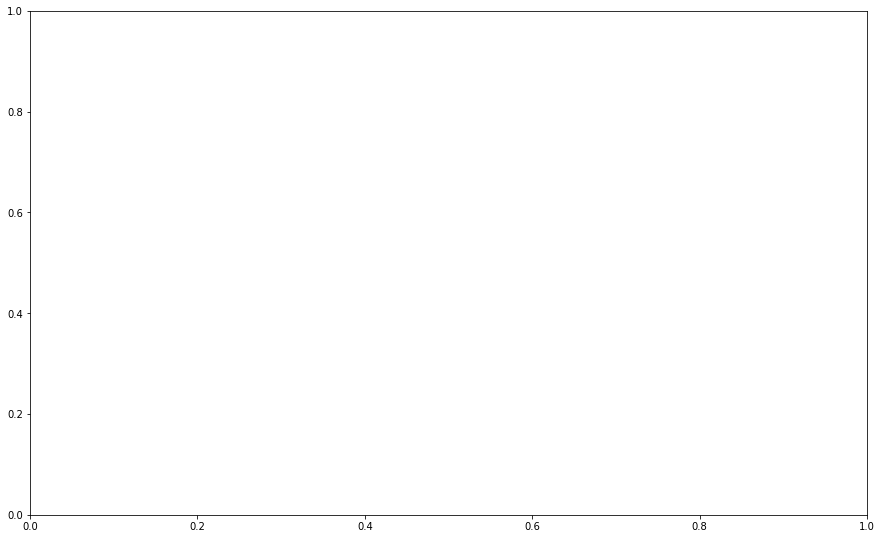

In [73]:
figwidth = 15
fig = plt.figure(figsize = (figwidth, figwidth/1.618))
ax_D = fig.add_subplot(1, 1, 1)
width = .8*np.abs(np.gradient(eccentricities)[0])
colors = ('orange','blue','red','yellow','cyan','purple')
for num_saccade in [2, 1, 0]:
    if num_saccade <2:
        label = str(num_saccade)+' saccade'
    else:
        label = str(num_saccade)+' saccades'
    ax_D.bar(eccentricities, accuracy_mean[num_saccade], width=width, alpha = .5, label = label, color=colors[num_saccade])#yerr=accuracy_std, 
# TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
#ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
#ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1]);

NameError: name 'eccentricities' is not defined

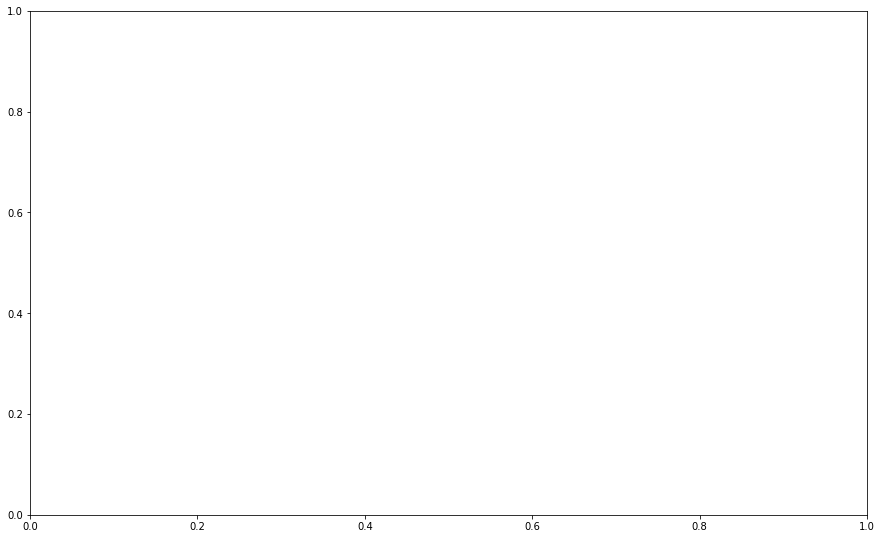

In [74]:
figwidth = 15
fig = plt.figure(figsize = (figwidth, figwidth/1.618))
ax_D = fig.add_subplot(1, 1, 1)
width = .8*np.abs(np.gradient(eccentricities)[0])
colors = ('orange','blue','red','yellow','cyan','purple')
for num_saccade in [3, 2, 1, 0]:
    if num_saccade <2:
        label = str(num_saccade)+' saccade'
    else:
        label = str(num_saccade)+' saccades'
    ax_D.bar(eccentricities, accuracy_mean[num_saccade], width=width, alpha = .5, label = label, color=colors[num_saccade])#yerr=accuracy_std, 
# TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
#ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
#ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1]);

NameError: name 'eccentricities' is not defined

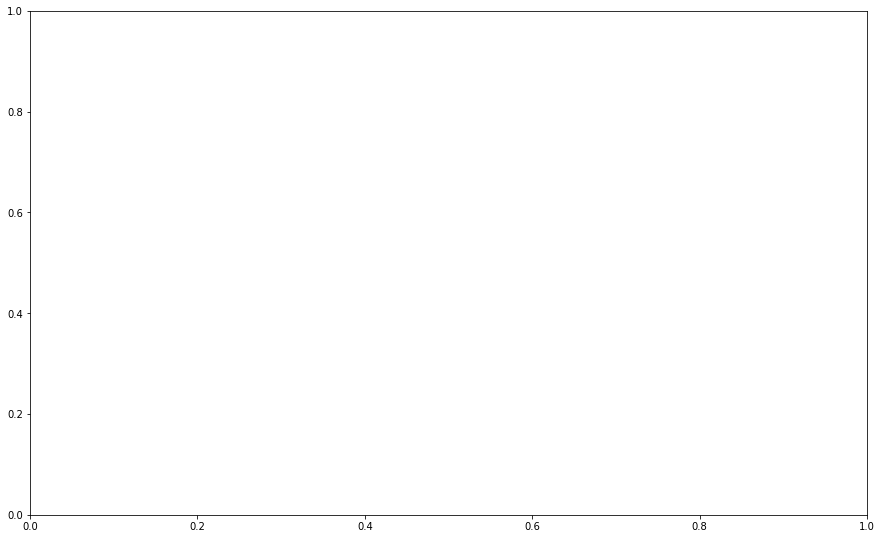

In [75]:
figwidth = 15
fig = plt.figure(figsize = (figwidth, figwidth/1.618))
ax_D = fig.add_subplot(1, 1, 1)
width = .8*np.abs(np.gradient(eccentricities)[0])
colors = ('orange','blue','red','yellow','cyan','purple')
for num_saccade in [4, 3, 2, 1, 0]:
    if num_saccade <2:
        label = str(num_saccade)+' saccade'
    else:
        label = str(num_saccade)+' saccades'
    ax_D.bar(eccentricities, accuracy_mean[num_saccade], width=width, alpha = .5, label = label, color=colors[num_saccade])#yerr=accuracy_std, 
# TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
#ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
#ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1]);

# summary


In [76]:
#ctl_accuracy_mean = accuracy_mean[0]
from where import WhereShift
idx = 13
fullfield = data_fullfield[idx, :, :]

fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 4, 1) 
data_retina = where.retina.retina(fullfield)
ax_A = where.retina.show(ax_A, where.retina.retina_invert(data_retina))
    
ax_B = plt.subplot(2, 4, 2, projection='polar', autoscale_on=False)
ax_B.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(where.retina.theta_grid, where.retina.log_r_grid, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])

ax_C = plt.subplot(1, 4, 3)
#data_fullfield_ = where.display.place_object(data[idx, 0, :, :].numpy(), 0, 0)
i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
data_fullfield_ = WhereShift(args, i_offset=-i_pred, j_offset=-j_pred, baseline=0.5)((fullfield, 0)) 
input_vector  =  where.retina.retina(data_fullfield_)
ax_C = where.retina.show(ax_C, where.retina.retina_invert(input_vector))
#ax_A.arrow(64.5, 64.5, j_pred, i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
ax_C.arrow(args.N_pic//2+j_pred+14, args.N_pic//2+i_pred+14, -j_pred, -i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
ax_C.arrow(args.N_pic//2+j_pred+14, args.N_pic//2+i_pred-14, -j_pred, -i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')

ax_D = plt.subplot(1, 4, 4)
#width = .8*np.abs(np.gradient(eccentricities)[0])
if not linear:
    width = .3*np.abs(eccentricities)
else:
    width = 4
ax_D.bar(eccentricities, accuracy_mean[1], width=width, color='blue', alpha = .5, label = 'One saccade')
ax_D.bar(eccentricities, accuracy_mean[0], width=width, color='orange', alpha = .5, label = 'No saccade')
width = .5
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
#ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [acc_max]*2, ':', c='k', label = 'Max')

plt.legend(loc='upper right')
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_ylim([0,1])
if not linear:
    ax_D.set_xscale('log')
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
if not linear:
    ax_D.set_xlim([1.3,30])

for ax, text in [[ax_A, 'DIS'], [ax_C, 'SAC']]:
    ax.text(4, 15, text, fontsize=24,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15], [ax_D, 'D', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])
ax_D.set_position([0.65, .1, .3, .45])
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

NameError: name 'data_fullfield' is not defined

In [77]:
_ = plt.plot(fullfield.detach().numpy())

NameError: name 'fullfield' is not defined

# post-processing

In [78]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

convert: invalid argument for option '-density': {dpi_export} @ error/convert.c/ConvertImageCommand/1292.
convert: invalid argument for option '-density': {dpi_export} @ error/convert.c/ConvertImageCommand/1292.


In [79]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

FileNotFoundError: No such file or directory: '../paper/fig_result_robust_contrast_linear_0.7_1.png'

FileNotFoundError: No such file or directory: '../paper/fig_result_robust_contrast_linear_0.7_1.png'

<IPython.core.display.Image object>

In [80]:
!ls  -l {figname}*

ls: ../paper/fig_result_robust_contrast_linear_0.7_1*: No such file or directory
